# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Clustering](#Clustering)
    - [4-Seam Fastball](#4-Seam-Fastball)
        - [4-Seam Cluster Label](#Cluster-Labels---4-Seam)
    - [Slider](#Slider)
        - [Slider Cluster Label](#Cluster-Labels---Slider)
    - [Changeup](#Changeup)
        - [Changeup Cluster Label](#Cluster-Labels---Changeup)
    - [Cutter](#Cutter)
        - [Cutter Cluster Label](#Cluster-Labels---Cutter)

# Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, k_means
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches.csv')
data.drop(columns = ['Unnamed: 0'], inplace = True) 
data.dropna(inplace = True)

pd.set_option('max_columns', None)
print(data.shape)
data.head(5)

(680887, 24)


,pitch_type,velo,spin_rate,spin_axis,pfx_-x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,swing_miss,delta_run_exp,hit_distance_sc,exit_velo,launch_angle,launch_speed_angle,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value
0,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,1.40,6.80,6.5,54.03,0,-0.073,13.0,95.2,-13.0,2.0,0.174,0.158,0.0,1.0,0.0,0.0
1,SL,80.6,2254.0,315.0,9.24,5.76,27.965261,81.2,1.60,6.64,6.4,54.15,0,-0.027,108.0,75.3,75.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0
2,CU,75.5,1940.0,328.0,7.80,-6.12,25.695364,75.2,1.46,6.88,6.2,54.34,0,-0.020,157.0,83.5,65.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0
3,CU,75.0,2017.0,330.0,8.28,-8.28,26.893333,74.5,1.53,6.83,5.9,54.61,0,0.016,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0
4,FF,91.2,2281.0,143.0,-7.56,15.36,25.010965,90.9,1.49,6.66,6.3,54.15,0,-0.189,9.0,93.3,-18.0,2.0,0.100,0.090,0.0,1.0,0.0,0.0


Pitch Types:

4-Seam, Cutter, Sinker, Slider, Curveball, Changeup

# Preprocessing

### Multicolinearity - VIF

In [3]:
features = data.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features.columns

vif_data["VIF"] = [variance_inflation_factor(features.values, i)
                   for i in range(len(features.columns))]

vif_data.sort_values(by = 'VIF').head(15)

,feature,VIF
11,swing_miss,1.435700
7,release_pos_x,1.685610
15,launch_angle,2.508363
3,pfx_-x,3.341261
12,delta_run_exp,3.934273
4,pfx_z,5.052088
21,babip_value,5.172847
14,exit_velo,5.176083
20,woba_denom,5.194216
22,iso_value,5.934894


# Features

In [4]:
features = data[['swing_miss', 'launch_angle', 'pfx_-x', 'delta_run_exp', 'pfx_z',
                 'babip_value', 'exit_velo', 'iso_value', 'launch_speed_angle', 
                 'woba_value', 'spin_axis', 'estimated_ba_using_speedangle', 
                 'estimated_woba_using_speedangle', 'velo', 'spin_rate', 'spin_axis', 
                 'bauer_units', 'pitch_type']]

In [5]:
ff = features.loc[features['pitch_type'] == 'FF']
fc = features.loc[features['pitch_type'] == 'FC']
si = features.loc[features['pitch_type'] == 'SI']
sl = features.loc[features['pitch_type'] == 'SL']
cu = features.loc[features['pitch_type'] == 'CU']
ch = features.loc[features['pitch_type'] == 'CH']

# Clustering 

## 4-Seam Fastball

In [6]:
features_ff = ff.select_dtypes([np.number])
X_ff = features_ff

ss = StandardScaler()
X_ff_scaled = ss.fit_transform(X_ff)
X_ff_scaled[:,:] *= -1

pca = PCA().fit(X_ff_scaled)
principal_components_ff = pca.transform(X_ff_scaled)
model_ff = pd.DataFrame(data = principal_components_ff, columns = X_ff.columns)

km_ff = KMeans(n_clusters = 2, 
               random_state = 1)
km_ff.fit(model_ff)
label_ff = km_ff.fit_predict(model_ff)

print('Number of iterations:', km_ff.n_iter_)
print('Number of features:', km_ff.n_features_in_)
print('Number of clusters:', km_ff.n_clusters)
print('Inertia:', km_ff.inertia_, '\n')
print('Predicted clusters to points: ', label_ff[:10], '\n')

Number of iterations: 18
Number of features: 17
Number of clusters: 2
Inertia: 3237110.514762227 

Predicted clusters to points:  [0 0 0 0 0 0 0 0 0 0] 



### Cluster Labels - 4-Seam

In [7]:
# 0 bad, 1 good

X_ff['label'] = label_ff
model_ff['label'] = label_ff
#model_ff.groupby(by = 'label').mean().T
X_ff.groupby(by = 'label').mean().T

label,0,1
swing_miss,0.098256,0.000000
launch_angle,9.452237,14.068443
pfx_-x,2.840762,2.843975
delta_run_exp,-0.038051,0.626672
pfx_z,16.132678,15.600033
babip_value,0.000319,0.770934
exit_velo,25.128093,96.196090
iso_value,0.000000,0.727958
launch_speed_angle,0.318321,4.244706
woba_value,0.023342,1.110505


In [8]:
#score = silhouette_score(X_ff, label_ff, metric="euclidean")
#score

## Cutter

In [9]:
features_fc = fc.select_dtypes([np.number])
X_fc = features_fc

X_fc_scaled = ss.fit_transform(X_fc)
X_fc_scaled[:,:] *= -1

pca = PCA().fit(X_fc_scaled)
principal_components_fc = pca.transform(X_fc_scaled)
model_fc = pd.DataFrame(data = principal_components_fc, columns = X_fc.columns)

km_fc = KMeans(n_clusters = 2, 
               random_state = 1)

km_fc.fit(model_fc)
label_fc = km_fc.fit_predict(model_fc)

print('Number of iterations:', km_fc.n_iter_)
print('Number of features:', km_fc.n_features_in_)
print('Number of clusters:', km_fc.n_clusters)
print('Inertia:', km_fc.inertia_, '\n')
print("Predicted clusters to points: ", label_fc[:10], '\n')

Number of iterations: 6
Number of features: 17
Number of clusters: 2
Inertia: 614620.9433385754 

Predicted clusters to points:  [0 0 0 0 0 0 0 0 1 0] 



### Cluster Labels - Cutter

In [10]:
# 0 good, 1 bad

X_fc['label'] = label_fc
model_fc['label'] = label_fc

X_fc.groupby(by = 'label').mean().T

label,0,1
swing_miss,0.118096,0.000000
launch_angle,5.067943,13.456682
pfx_-x,-1.392984,-1.198469
delta_run_exp,-0.043368,0.639278
pfx_z,7.927986,7.862377
babip_value,0.000315,0.802552
exit_velo,24.869773,93.629752
iso_value,0.000000,0.637340
launch_speed_angle,0.345628,4.084956
woba_value,0.018487,1.083210


# Sinker

In [11]:
features_si = si.select_dtypes([np.number])
X_si = features_si

X_si_scaled = ss.fit_transform(X_si)
X_si_scaled[:,:] *= -1

pca = PCA().fit(X_si_scaled)
principal_components_si = pca.transform(X_si_scaled)
model_si = pd.DataFrame(data = principal_components_si, columns = X_si.columns)

km_si = KMeans(n_clusters = 2, 
               random_state = 1)

km_si.fit(model_si)
label_si = km_si.fit_predict(model_si)

print('Number of iterations:', km_si.n_iter_)
print('Number of features:', km_si.n_features_in_)
print('Number of clusters:', km_si.n_clusters)
print('Inertia:', km_si.inertia_, '\n')
print("Predicted clusters to points: ", label_si[:10], '\n')

Number of iterations: 6
Number of features: 17
Number of clusters: 2
Inertia: 1425075.478078641 

Predicted clusters to points:  [0 0 0 0 0 0 0 0 0 0] 



### Cluster Labels - Sinker

In [12]:
# 0 good, 1 bad

X_si['label'] = label_si
model_si['label'] = label_si

X_si.groupby(by = 'label').mean().T

label,0,1
swing_miss,0.067301,0.000000
launch_angle,3.088037,8.968103
pfx_-x,5.651040,5.600030
delta_run_exp,-0.043925,0.573510
pfx_z,9.254466,8.917179
babip_value,0.000286,0.821960
exit_velo,24.599173,94.527882
iso_value,0.000000,0.494980
launch_speed_angle,0.351139,3.898716
woba_value,0.025147,1.016222


## Slider

In [13]:
features_sl = sl.select_dtypes([np.number])
X_sl = features_sl

X_sl_scaled = ss.fit_transform(X_sl)
X_sl_scaled[:,:] *= -1

pca = PCA().fit(X_sl_scaled)
principal_components_sl = pca.transform(X_sl_scaled)
model_sl = pd.DataFrame(data = principal_components_sl, columns = X_sl.columns)

km_sl = KMeans(n_clusters = 2, 
               random_state = 1)

km_sl.fit(model_sl)
label_sl = km_sl.fit_predict(model_sl)

print('Number of iterations:', km_sl.n_iter_)
print('Number of features:', km_sl.n_features_in_)
print('Number of clusters:', km_sl.n_clusters)
print('Inertia:', km_sl.inertia_, '\n')
print("Predicted clusters to points: ", label_sl[:10], '\n')

Number of iterations: 14
Number of features: 17
Number of clusters: 2
Inertia: 1750198.9894203455 

Predicted clusters to points:  [1 1 1 1 1 1 1 1 1 1] 



### Cluster Labels - Slider

In [14]:
# 0 bad, 1 good

X_sl['label'] = label_sl
model_sl['label'] = label_sl

X_sl.groupby(by = 'label').mean().T

label,0,1
swing_miss,0.000000,0.171294
launch_angle,13.355340,3.295537
pfx_-x,-3.069703,-3.230665
delta_run_exp,0.682545,-0.041169
pfx_z,1.623695,1.708307
babip_value,0.783773,0.000249
exit_velo,92.960915,19.527437
iso_value,0.685992,0.000000
launch_speed_angle,4.078086,0.300228
woba_value,1.095763,0.016078


# Curveball

In [15]:
features_cu = cu.select_dtypes([np.number])
X_cu = features_cu

X_cu_scaled = ss.fit_transform(X_cu)
X_cu_scaled[:,:] *= -1

pca = PCA().fit(X_cu_scaled)
principal_components_cu = pca.transform(X_cu_scaled)
model_cu = pd.DataFrame(data = principal_components_cu, columns = X_cu.columns)

km_cu = KMeans(n_clusters = 2, 
               random_state = 1)

km_cu.fit(model_cu)
label_cu = km_cu.fit_predict(model_cu)

print('Number of iterations:', km_cu.n_iter_)
print('Number of features:', km_cu.n_features_in_)
print('Number of clusters:', km_cu.n_clusters)
print('Inertia:', km_cu.inertia_, '\n')
print("Predicted clusters to points: ", label_cu[:10], '\n')

Number of iterations: 6
Number of features: 17
Number of clusters: 2
Inertia: 837159.8332881856 

Predicted clusters to points:  [1 1 0 0 0 0 0 0 0 0] 



### Cluster Labels - Curveball

In [16]:
# 0 good, 1 bad

X_cu['label'] = label_cu
model_cu['label'] = label_cu

X_cu.groupby(by = 'label').mean().T

label,0,1
swing_miss,0.132415,0.110361
launch_angle,1.123659,3.057997
pfx_-x,-9.411845,7.136310
delta_run_exp,-0.031972,0.066021
pfx_z,-8.988132,-8.249836
babip_value,0.000410,0.118175
exit_velo,16.411017,28.965065
iso_value,0.000000,0.088949
launch_speed_angle,0.254256,0.843566
woba_value,0.011705,0.167452


## Changeup

In [17]:
features_ch = ch.select_dtypes([np.number])
X_ch = features_ch

X_ch_scaled = ss.fit_transform(X_ch)
X_ch_scaled[:,:] *= -1

pca = PCA().fit(X_ch_scaled)
principal_components_ch = pca.transform(X_ch_scaled)
model_ch = pd.DataFrame(data = principal_components_ch, columns = X_ch.columns)

km_ch = KMeans(n_clusters = 2, 
               random_state = 1)

km_ch.fit(model_ch)
label_ch = km_ch.fit_predict(model_ch)

print('Number of iterations:', km_ch.n_iter_)
print('Number of features:', km_ch.n_features_in_)
print('Number of clusters:', km_ch.n_clusters)
print('Inertia:', km_ch.inertia_, '\n')
print("Predicted clusters to points: ", label_ch[:10], '\n')

Number of iterations: 7
Number of features: 17
Number of clusters: 2
Inertia: 1041113.602309199 

Predicted clusters to points:  [0 0 1 0 0 0 0 0 0 0] 



### Cluster Labels - Changeup

In [18]:
# 0 good, 1 bad

X_ch['label'] = label_ch
model_ch['label'] = label_ch

X_ch.groupby(by = 'label').mean().T

label,0,1
swing_miss,0.154924,0.000000
launch_angle,1.657518,11.543251
pfx_-x,3.662107,2.630644
delta_run_exp,-0.040752,0.641549
pfx_z,6.828419,6.828107
babip_value,0.000213,0.806633
exit_velo,22.256688,92.349922
iso_value,0.000000,0.605896
launch_speed_angle,0.370926,3.982739
woba_value,0.015667,1.068832


# Modeling

## Linear Regression - 4-Seam

### Heatmaps of Features - 4-Seam

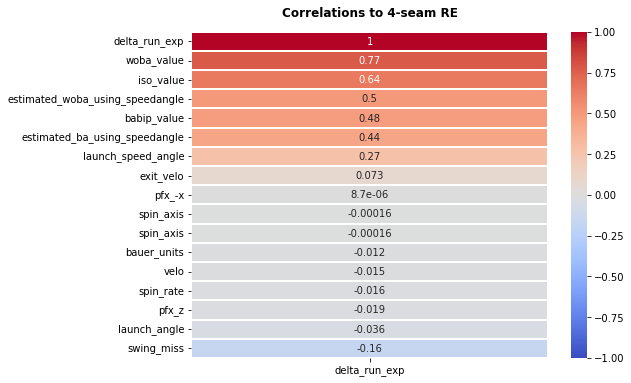

In [19]:
plt.figure(figsize = (8, 6))
sns.heatmap(ff.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), 
                                                     ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to 4-seam RE', fontweight = 'bold', pad = 15);

Positively correlated with label, as the positive values increase the run exp increases

Negatively correlated with lablel, as the negative values increase the run exp decreases and vice versa

Positively correlated with label, as the positive values increase the label increases

Negatively correlated with lablel, as the negative values increase the label decreases and vice versa

In [20]:
#X = X_ff.drop(columns = ['delta_run_exp'])
#y = X_ff['delta_run_exp']
#
#lr = LinearRegression()
#lr.fit(X, y)
#pred_ff = lr.predict(X)
#score_ff = lr.score(X, y)
#
#print('R2 score:', round(score_ff, 3)) 
#print('MSE:', round(metrics.mean_squared_error(y, pred_ff), 4))
#print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ff)), 4))
#print('MAE:', round(metrics.mean_absolute_error(y, pred_ff), 4))
#print('Cross val score', round(cross_val_score(lr, X, y).mean(), 4))

In [21]:
X = X_ff.drop(columns = ['delta_run_exp'])
y = X_ff['delta_run_exp']

#X = np.concatenate([X, np.ones((X.shape[0], 1))], axis = 1)

model = sm.OLS(y, X, hasconst = True)
model = model.fit()
pred_ff = model.predict(X)

print('MSE:', round(metrics.mean_squared_error(y, pred_ff), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ff)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ff), 4))
#print('Cross val score', round(cross_val_score(model, X, y).mean(), 4))

model.summary()

MSE: 0.0169
RMSE: 0.13
MAE: 0.0768


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                 4.032e+04
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        00:22:53   Log-Likelihood:             1.5510e+05
No. Observations:              249672   AIC:                        -3.102e+05
Df Residuals:                  249656   BIC:                        -3.100e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
swing_miss                         -0.1217      0.001   -130.944      0.000      -0.123      -0.120
launch_angle                        0.0005   1.62e-05     30.078      0.000       0.000       0.001
pfx_-x                           2.237e-05    8.3e-05      0.270      0.787      -0.000       0.000
pfx_z                              -0.0001   8.76e-05     -1.441      0.150      -0.000    4.55e-05
babip_value                         0.1797      0.004     42.068      0.000       0.171       0.188
exit_velo                          -0.0008   1.08e-05    -76.170      0.000      -0.001      -0.001
iso_value                           0.2428      0.002    125.304      0.000       0.239       0.247
launch_speed_angle                 -0.0672      0.000   -161.926      0.000      -0.068      -0.066
woba_value                          0.3641      0.002    173.881      0.000       0.360       0.368
spin_axis                        2.762e-06   9.81e-06      0.281      0.778   -1.65e-05     2.2e-05
estimated_ba_using_speedangle       0.0238      0.007      3.280      0.001       0.010       0.038
estimated_woba_using_speedangle     0.0888      0.006     14.882      0.000       0.077       0.101
velo                             5.111e-05   5.56e-05      0.919      0.358   -5.79e-05       0.000
spin_rate                        1.359e-05   5.05e-06      2.692      0.007     3.7e-06    2.35e-05
spin_axis                        2.762e-06   9.81e-06      0.281      0.778   -1.65e-05     2.2e-05
bauer_units                        -0.0014      0.000     -3.179      0.001      -0.002      -0.001
label                               0.1813      0.004     40.954      0.000       0.173       0.190
==============================================================================
Omnibus:                   107617.538   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6632607.834
Skew:                           1.265   Prob(JB):                         0.00
Kurtosis:                      28.123   Cond. No.                     5.67e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.1e-20. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

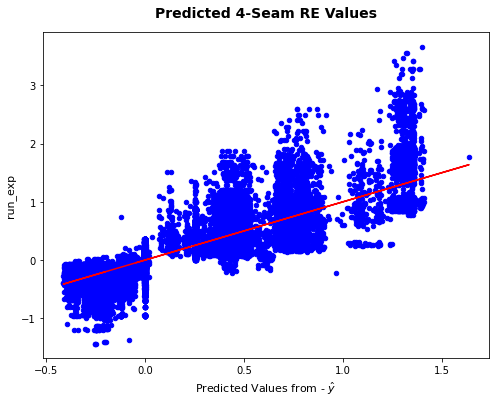

In [22]:
plt.figure(figsize = (8,6))
plt.scatter(pred_ff, y, s = 20, c = 'b', marker = 'o')
plt.plot(pred_ff, np.poly1d(np.polyfit(pred_ff, y, 1))(pred_ff), c = 'r')
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11)
plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted 4-Seam RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Cutter

### Heatmap of Features - Cutter

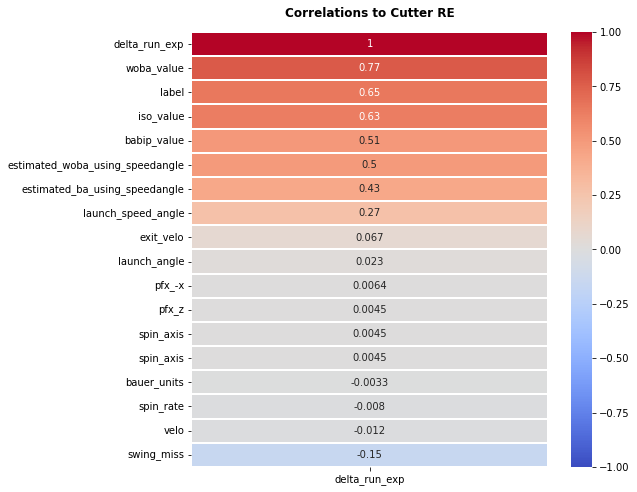

In [23]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_fc.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Cutter RE', fontweight = 'bold', pad = 15);

In [24]:
X = X_fc.drop(columns = ['delta_run_exp'])
y = X_fc['delta_run_exp']

#X = np.concatenate([X, np.ones((X.shape[0], 1))], axis = 1)

model = sm.OLS(y, X, hasconst = True)
model = model.fit()
pred_fc = model.predict(X)

print('MSE:', round(metrics.mean_squared_error(y, pred_fc), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_fc)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_fc), 4))
#print('Cross val score', round(cross_val_score(lr, X, y).mean(), 4))

model.summary()

MSE: 0.0187
RMSE: 0.1366
MAE: 0.0804


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     7716.
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        00:22:54   Log-Likelihood:                 27111.
No. Observations:               47442   AIC:                        -5.419e+04
Df Residuals:                   47426   BIC:                        -5.405e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
swing_miss                         -0.1140      0.002    -54.808      0.000      -0.118      -0.110
launch_angle                        0.0004   3.28e-05     12.948      0.000       0.000       0.000
pfx_-x                             -0.0001      0.000     -0.567      0.571      -0.000       0.000
pfx_z                              -0.0004      0.000     -2.371      0.018      -0.001    -7.1e-05
babip_value                         0.1434      0.010     14.209      0.000       0.124       0.163
exit_velo                          -0.0008   2.23e-05    -37.905      0.000      -0.001      -0.001
iso_value                           0.1995      0.005     41.163      0.000       0.190       0.209
launch_speed_angle                 -0.0750      0.001    -72.542      0.000      -0.077      -0.073
woba_value                          0.4201      0.006     75.337      0.000       0.409       0.431
spin_axis                        2.359e-05   1.04e-05      2.263      0.024    3.16e-06     4.4e-05
estimated_ba_using_speedangle      -0.1245      0.017     -7.359      0.000      -0.158      -0.091
estimated_woba_using_speedangle     0.2549      0.014     17.632      0.000       0.227       0.283
velo                            -3.842e-05   9.07e-05     -0.423      0.672      -0.000       0.000
spin_rate                       -1.685e-06   8.32e-06     -0.203      0.839    -1.8e-05    1.46e-05
spin_axis                        2.359e-05   1.04e-05      2.263      0.024    3.16e-06     4.4e-05
bauer_units                         0.0002      0.001      0.347      0.729      -0.001       0.002
label                               0.2108      0.010     20.233      0.000       0.190       0.231
==============================================================================
Omnibus:                    17566.891   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           894027.682
Skew:                           1.019   Prob(JB):                         0.00
Kurtosis:                      24.169   Cond. No.                     1.61e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.05e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

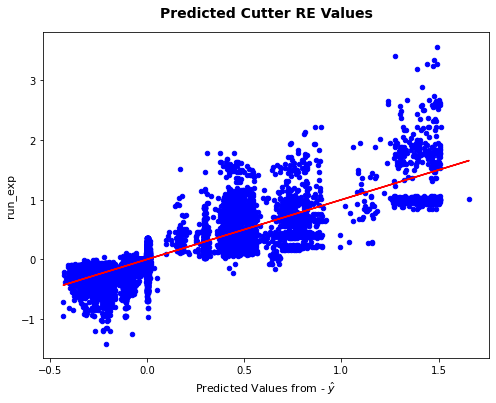

In [25]:
plt.figure(figsize = (8,6))
plt.scatter(pred_fc, y, s = 20, c = 'b', marker = 'o')
plt.plot(pred_fc, np.poly1d(np.polyfit(pred_fc, y, 1))(pred_fc), c = 'r')
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11)
plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted Cutter RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Sinker

### Heatmap of Features - Sinker

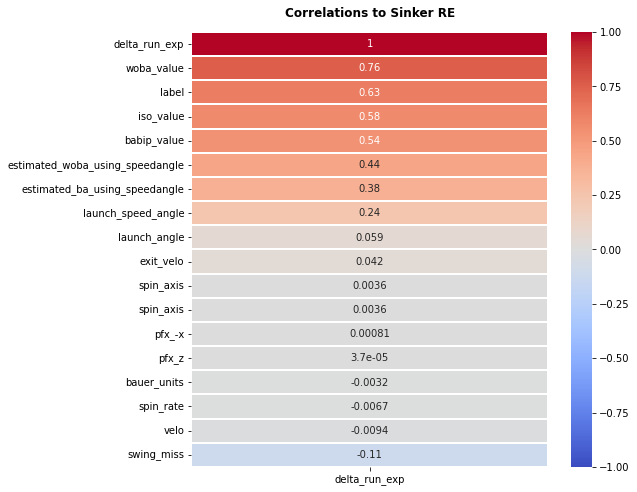

In [26]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_si.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Sinker RE', fontweight = 'bold', pad = 15);

In [27]:
X = X_si.drop(columns = ['delta_run_exp'])
y = X_si['delta_run_exp']

#X = np.concatenate([X, np.ones((X.shape[0], 1))], axis = 1)

model = sm.OLS(y, X, hasconst = True)
model = model.fit()
pred_si = model.predict(X)

print('MSE:', round(metrics.mean_squared_error(y, pred_si), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_si)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_si), 4))
#print('Cross val score', round(cross_val_score(lr, X, y).mean(), 4))

model.summary()

MSE: 0.0194
RMSE: 0.1392
MAE: 0.0849


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                 1.686e+04
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        00:22:55   Log-Likelihood:                 60335.
No. Observations:              109145   AIC:                        -1.206e+05
Df Residuals:                  109129   BIC:                        -1.205e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
swing_miss                         -0.1078      0.002    -60.621      0.000      -0.111      -0.104
launch_angle                        0.0006   2.19e-05     29.203      0.000       0.001       0.001
pfx_-x                          -7.394e-05   9.04e-05     -0.818      0.413      -0.000       0.000
pfx_z                           -5.976e-05   9.65e-05     -0.619      0.536      -0.000       0.000
babip_value                         0.1687      0.006     28.159      0.000       0.157       0.180
exit_velo                          -0.0009   1.49e-05    -59.586      0.000      -0.001      -0.001
iso_value                           0.2317      0.003     74.904      0.000       0.226       0.238
launch_speed_angle                 -0.0752      0.001   -100.543      0.000      -0.077      -0.074
woba_value                          0.4068      0.003    125.173      0.000       0.400       0.413
spin_axis                        9.839e-06   1.48e-05      0.665      0.506   -1.92e-05    3.88e-05
estimated_ba_using_speedangle      -0.0065      0.011     -0.563      0.573      -0.029       0.016
estimated_woba_using_speedangle     0.1154      0.010     11.289      0.000       0.095       0.135
velo                               -0.0002   8.19e-05     -1.935      0.053      -0.000    2.06e-06
spin_rate                        1.305e-05   7.66e-06      1.704      0.088   -1.96e-06    2.81e-05
spin_axis                        9.839e-06   1.48e-05      0.665      0.506   -1.92e-05    3.88e-05
bauer_units                        -0.0008      0.001     -1.292      0.196      -0.002       0.000
label                               0.2098      0.006     34.641      0.000       0.198       0.222
==============================================================================
Omnibus:                    35125.949   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1497301.026
Skew:                           0.834   Prob(JB):                         0.00
Kurtosis:                      21.068   Cond. No.                     2.29e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.64e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

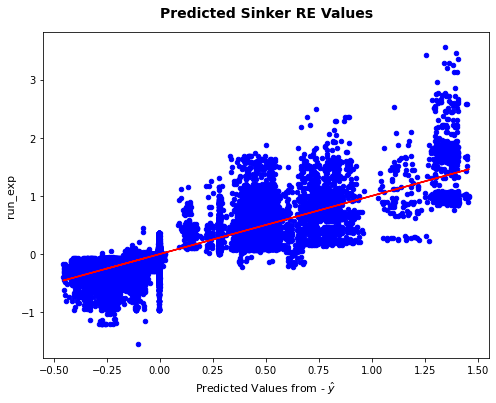

In [28]:
plt.figure(figsize = (8,6))
plt.scatter(pred_si, y, s = 20, c = 'b', marker = 'o')
plt.plot(pred_si, np.poly1d(np.polyfit(pred_si, y, 1))(pred_si), c = 'r')
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11)
plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted Sinker RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Slider

### Heatmap of Features - Slider

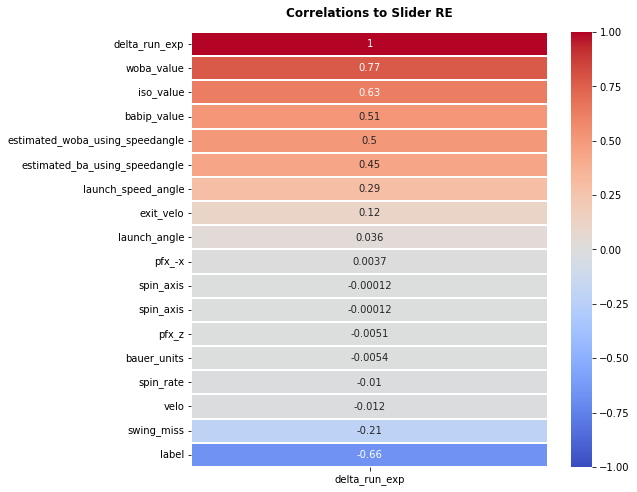

In [29]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_sl.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Slider RE', fontweight = 'bold', pad = 15);

In [30]:
X = X_sl.drop(columns = ['delta_run_exp'])
y = X_sl['delta_run_exp']

#X = np.concatenate([X, np.ones((X.shape[0], 1))], axis = 1)

model = sm.OLS(y, X, hasconst = True)
model = model.fit()
pred_sl = model.predict(X)

print('MSE:', round(metrics.mean_squared_error(y, pred_sl), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_sl)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_sl), 4))
#print('Cross val score', round(cross_val_score(lr, X, y).mean(), 4))

model.summary()

MSE: 0.018
RMSE: 0.1341
MAE: 0.0789


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                 2.167e+04
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        00:22:56   Log-Likelihood:                 79978.
No. Observations:              135539   AIC:                        -1.599e+05
Df Residuals:                  135523   BIC:                        -1.598e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
swing_miss                         -0.1302      0.001   -126.013      0.000      -0.132      -0.128
launch_angle                        0.0004   2.08e-05     20.455      0.000       0.000       0.000
pfx_-x                           7.549e-05   7.62e-05      0.990      0.322   -7.39e-05       0.000
pfx_z                              -0.0003   8.82e-05     -3.575      0.000      -0.000      -0.000
babip_value                         0.1532      0.006     24.988      0.000       0.141       0.165
exit_velo                          -0.0008   1.43e-05    -54.957      0.000      -0.001      -0.001
iso_value                           0.2132      0.003     72.386      0.000       0.207       0.219
launch_speed_angle                 -0.0695      0.001   -106.094      0.000      -0.071      -0.068
woba_value                          0.4455      0.003    129.717      0.000       0.439       0.452
spin_axis                        6.176e-07   3.16e-06      0.195      0.845   -5.58e-06    6.81e-06
estimated_ba_using_speedangle      -0.0320      0.011     -3.033      0.002      -0.053      -0.011
estimated_woba_using_speedangle     0.1436      0.009     16.051      0.000       0.126       0.161
velo                                0.0024    8.7e-05     27.271      0.000       0.002       0.003
spin_rate                       -7.426e-05   5.16e-06    -14.390      0.000   -8.44e-05   -6.41e-05
spin_axis                        6.176e-07   3.16e-06      0.195      0.845   -5.58e-06    6.81e-06
bauer_units                         0.0061      0.000     15.575      0.000       0.005       0.007
label                              -0.1893      0.006    -29.919      0.000      -0.202      -0.177
==============================================================================
Omnibus:                    53255.630   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3058924.065
Skew:                           1.097   Prob(JB):                         0.00
Kurtosis:                      26.170   Cond. No.                     5.00e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.23e-20. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

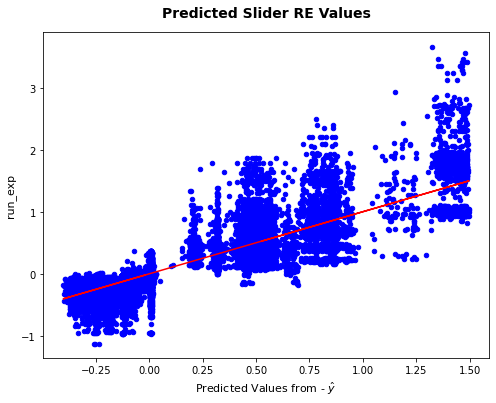

In [31]:
plt.figure(figsize = (8,6))
plt.scatter(pred_sl, y, s = 20, c = 'b', marker = 'o')
plt.plot(pred_sl, np.poly1d(np.polyfit(pred_sl, y, 1))(pred_sl), c = 'r')
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11)
plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted Slider RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Curveball

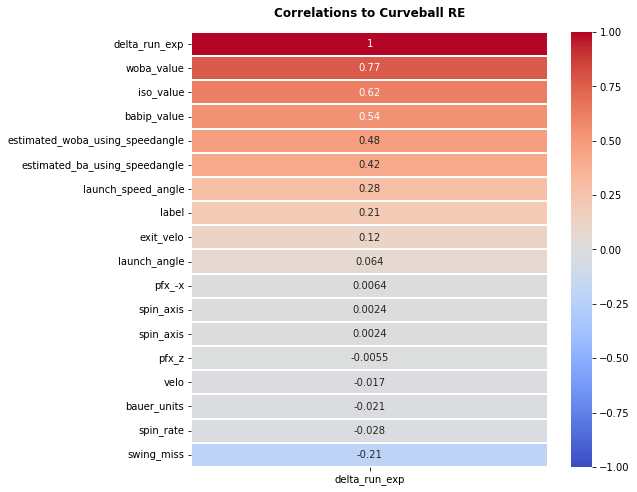

In [32]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_cu.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Curveball RE', fontweight = 'bold', pad = 15);

In [33]:
X = X_cu.drop(columns = ['delta_run_exp'])
y = X_cu['delta_run_exp']

model = sm.OLS(y, X, hasconst = True)
model = model.fit()
pred_cu = model.predict(X)

print('MSE:', round(metrics.mean_squared_error(y, pred_cu), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_cu)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_cu), 4))
#print('Cross val score', round(cross_val_score(model, X, y).mean(), 4))
model.summary()

MSE: 0.0145
RMSE: 0.1206
MAE: 0.0697


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     9495.
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        00:22:56   Log-Likelihood:                 40918.
No. Observations:               58767   AIC:                        -8.180e+04
Df Residuals:                   58751   BIC:                        -8.166e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
swing_miss                         -0.1270      0.002    -82.097      0.000      -0.130      -0.124
launch_angle                        0.0004   3.15e-05     13.006      0.000       0.000       0.000
pfx_-x                          -5.439e-05   9.14e-05     -0.595      0.552      -0.000       0.000
pfx_z                              -0.0003   9.59e-05     -3.041      0.002      -0.000      -0.000
babip_value                         0.2649      0.006     46.030      0.000       0.254       0.276
exit_velo                          -0.0006   2.06e-05    -31.418      0.000      -0.001      -0.001
iso_value                           0.2077      0.004     48.873      0.000       0.199       0.216
launch_speed_angle                 -0.0673      0.001    -67.005      0.000      -0.069      -0.065
woba_value                          0.4745      0.005     90.785      0.000       0.464       0.485
spin_axis                       -4.487e-05   6.63e-06     -6.766      0.000   -5.79e-05   -3.19e-05
estimated_ba_using_speedangle      -0.1453      0.015     -9.708      0.000      -0.175      -0.116
estimated_woba_using_speedangle     0.2593      0.013     20.636      0.000       0.235       0.284
velo                                0.0002   5.11e-05      4.793      0.000       0.000       0.000
spin_rate                       -1.461e-07   4.81e-06     -0.030      0.976   -9.58e-06    9.29e-06
spin_axis                       -4.487e-05   6.63e-06     -6.766      0.000   -5.79e-05   -3.19e-05
bauer_units                        -0.0004      0.000     -1.264      0.206      -0.001       0.000
label                               0.0281      0.004      7.391      0.000       0.021       0.036
==============================================================================
Omnibus:                    28500.486   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2298833.501
Skew:                           1.458   Prob(JB):                         0.00
Kurtosis:                      33.501   Cond. No.                     2.77e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.91e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

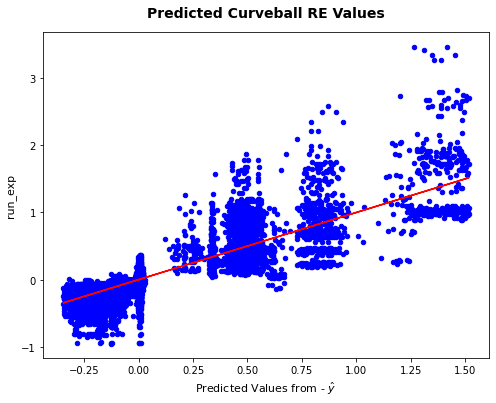

In [34]:
plt.figure(figsize = (8,6))
plt.scatter(pred_cu, y, s = 20, c = 'b', marker = 'o')
plt.plot(pred_cu, np.poly1d(np.polyfit(pred_cu, y, 1))(pred_cu), c = 'r')
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11)
plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted Curveball RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Changeup

### Heatmap of Features - Changeup

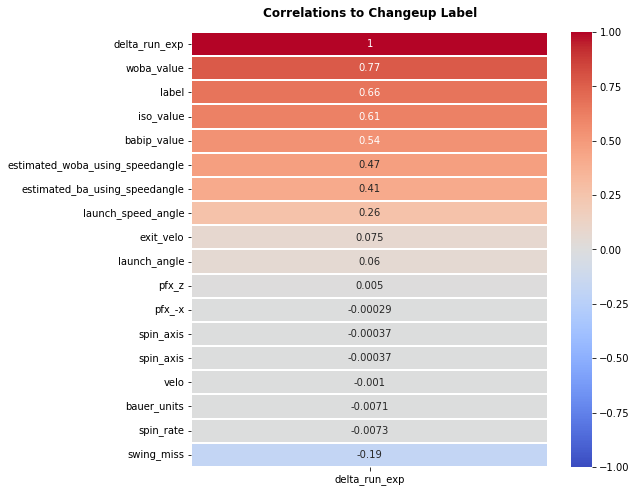

In [35]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_ch.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), 
                                                       ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Changeup Label', fontweight = 'bold', pad = 15);

In [36]:
X = X_ch.drop(columns = ['delta_run_exp'])
y = X_ch['delta_run_exp']

model = sm.OLS(y, X, hasconst = True)
model = model.fit()
pred_ch = model.predict(X)

print('MSE:', round(metrics.mean_squared_error(y, pred_ch), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ch)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ch), 4))
#print('Cross val score', round(cross_val_score(model, X, y).mean(), 4))
model.summary()

MSE: 0.0175
RMSE: 0.1322
MAE: 0.0768


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                 1.403e+04
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        00:22:57   Log-Likelihood:                 48530.
No. Observations:               80322   AIC:                        -9.703e+04
Df Residuals:                   80306   BIC:                        -9.688e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
swing_miss                         -0.1270      0.001    -91.588      0.000      -0.130      -0.124
launch_angle                        0.0005   2.48e-05     19.946      0.000       0.000       0.001
pfx_-x                          -2.354e-05      0.000     -0.216      0.829      -0.000       0.000
pfx_z                           -2.915e-05      0.000     -0.291      0.771      -0.000       0.000
babip_value                         0.1695      0.007     23.244      0.000       0.155       0.184
exit_velo                          -0.0010   1.81e-05    -56.089      0.000      -0.001      -0.001
iso_value                           0.2237      0.004     60.847      0.000       0.217       0.231
launch_speed_angle                 -0.0684      0.001    -82.806      0.000      -0.070      -0.067
woba_value                          0.4171      0.004     94.564      0.000       0.408       0.426
spin_axis                        7.088e-06   1.31e-05      0.541      0.588   -1.86e-05    3.28e-05
estimated_ba_using_speedangle       0.0181      0.013      1.426      0.154      -0.007       0.043
estimated_woba_using_speedangle     0.0850      0.011      7.621      0.000       0.063       0.107
velo                                0.0002   6.52e-05      3.292      0.001    8.69e-05       0.000
spin_rate                       -5.089e-06   7.58e-06     -0.672      0.502   -1.99e-05    9.76e-06
spin_axis                        7.088e-06   1.31e-05      0.541      0.588   -1.86e-05    3.28e-05
bauer_units                         0.0002      0.001      0.394      0.694      -0.001       0.001
label                               0.1988      0.007     26.686      0.000       0.184       0.213
==============================================================================
Omnibus:                    31086.626   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1581854.856
Skew:                           1.102   Prob(JB):                         0.00
Kurtosis:                      24.629   Cond. No.                     1.46e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.22e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

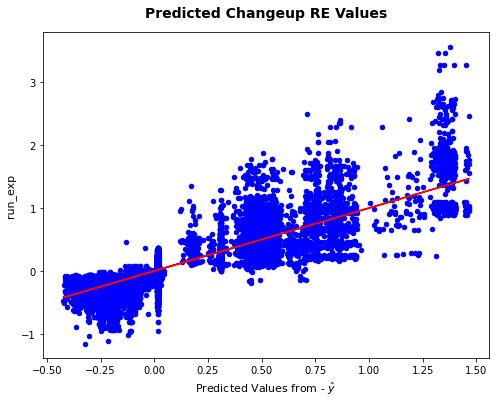

In [37]:
plt.figure(figsize = (8,6))
plt.scatter(pred_ch, y, s = 20, c = 'b', marker = 'o')
plt.plot(pred_ch, np.poly1d(np.polyfit(pred_ch, y, 1))(pred_ch), c = 'r')
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11)
plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted Changeup RE Values', fontsize = 14, fontweight = 'bold', pad = 15);